# Market Simulation

<b>Description:</b> This notebooks runs the market clearing simulation given multiple bidder objects to measure performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.MarketSimulator import *

## Load Energy Storage and Price Data

In [6]:
# load storage data
ENERGY_STORAGE_DATA_PATH = (
    "./src/CAISO-EnergyStorage/src/data/ES_BIDS/CAISO_ES_BIDS.parquet"
)
STORAGE_DF = pd.read_parquet(ENERGY_STORAGE_DATA_PATH)
STORAGE_DF = STORAGE_DF.ffill()

# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

# change storage data index to ts column
STORAGE_DF = STORAGE_DF.reset_index()
STORAGE_DF = STORAGE_DF.rename(columns={"datetime": "ts"})

# merge STORAGE_DF and CAISO_PRICES on datetime
storage_df = pd.merge(CAISO_PRICES, STORAGE_DF, on=["ts"], how="outer").dropna()

# add normalized demand
storage_df["normalized_demand"] = (
    # storage_df.tot_energy_rtpd
    # /
    storage_df.tot_energy_rtpd.rolling(window=16 * 288, center=True).max()
)

storage_df = storage_df.dropna()
storage_df

,ts,PGAE,SCE,SDGE,VEA,TH_NP15,TH_SP15,TH_ZP26,tot_energy_ifm,tot_energy_ruc,...,bid_rtpd_neg_3,bid_rtpd_neg_4,bid_rtpd_neg_5,bid_rtpd_neg_6,bid_rtpd_neg_7,bid_rtpd_neg_8,bid_rtpd_neg_9,bid_rtpd_neg_10,bid_rtpd_neg_11,normalized_demand
90148,2023-06-09 00:20:00,36.50000,36.99007,37.64650,36.17257,38.93386,38.93386,38.93386,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,3863.0
90149,2023-06-09 00:25:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,3863.0
90150,2023-06-09 00:30:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,3863.0
90151,2023-06-09 00:35:00,36.50000,36.99007,37.64650,36.17257,36.54614,36.54614,36.54614,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,3863.0
90152,2023-06-09 00:40:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,3863.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226360,2024-09-23 23:20:00,41.46547,41.75055,42.01971,40.48196,42.13150,42.45273,42.30851,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,8162.0
226361,2024-09-23 23:25:00,41.46547,41.75055,42.01971,40.48196,41.77966,42.09424,41.95124,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,8162.0
226362,2024-09-23 23:30:00,41.46547,41.75055,42.01971,40.48196,39.81464,42.21492,42.21492,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,8162.0
226363,2024-09-23 23:35:00,41.46547,41.75055,42.01971,40.48196,39.56826,41.96240,41.96240,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,8162.0


77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
77260.0 nan
7726

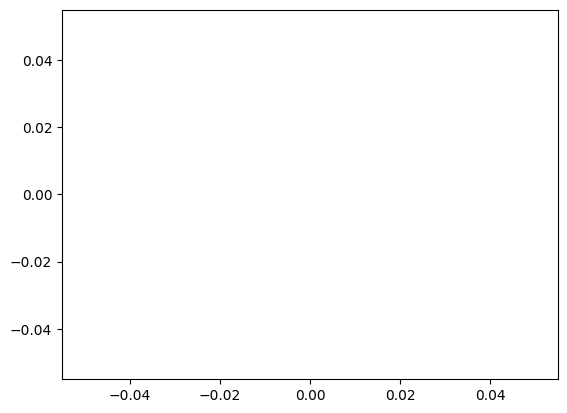

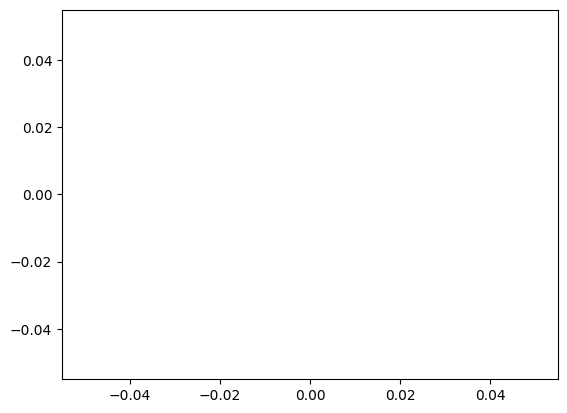

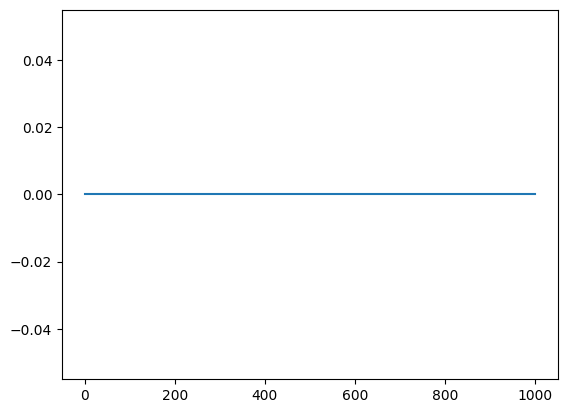

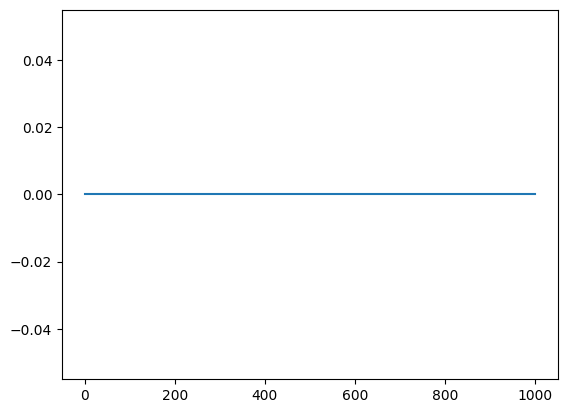

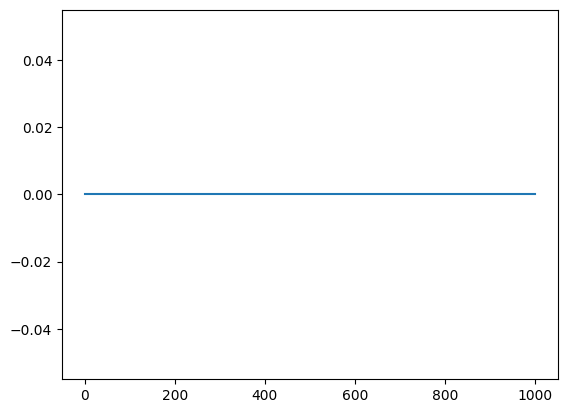

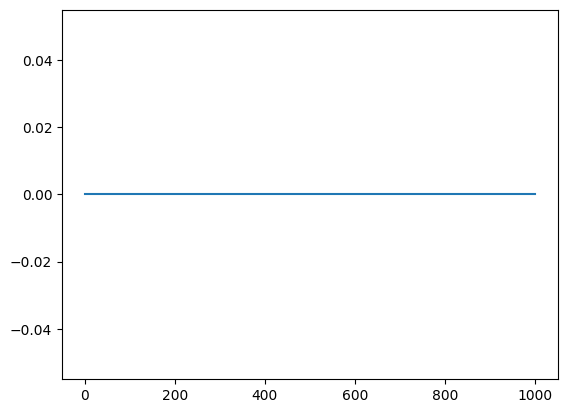

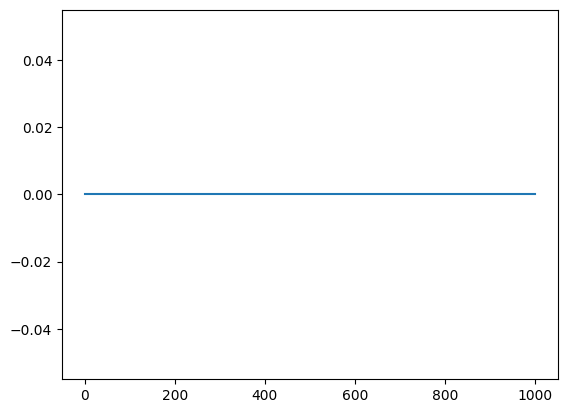

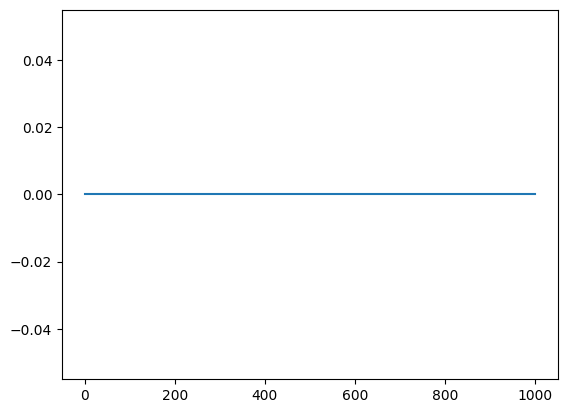

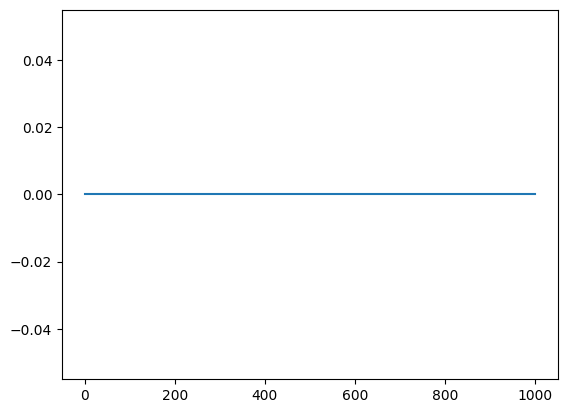

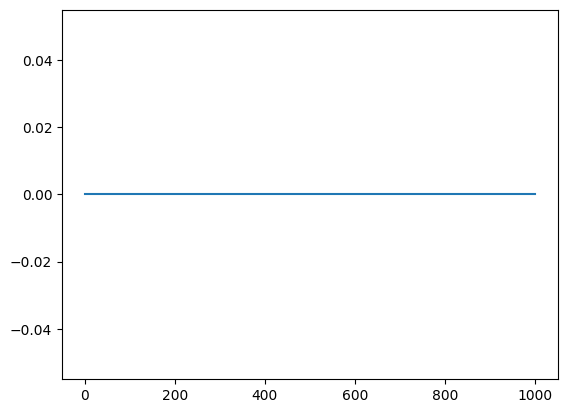

In [ ]:
Sim = MarketSimulator(storage_df)
honest_bidders = []
for i in range(10):
    honest_bidders.append(HonestBidder())
Sim.simulate(
    bidders=honest_bidders,
    min_lookback=288,
    rtp_col="TH_NP15",
    dap_col="PGAE",
    max_steps=1000,
)
# for bidder in honest_bidders:
#     plt.plot(bidder.profit_hist)
#     plt.show()